# EIANN Tutorial 1

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

# from EIANN._network import Network
import EIANN as eiann
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()
%load_ext autoreload
%autoreload 2

/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/utils/data_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1. Load MNIST data

In [2]:
# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../EIANN/data/mnist/datasets/MNIST_data/', train=True, download=True,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../EIANN/data/mnist/datasets/MNIST_data/',
                                        train=False, download=True, transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train[0:50000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

## 2. Build and train a simple feedforward neural network with EIANN

To build a neural network, you need to specify 3 things:
1. The number of neurons in each layer and sub-population
2. The projections (how the populations connect to each other)
3. The global parameters (e.g. learning rate, etc.)

Here we will build a simple feedforward network with 2 hidden layers and train it to classify MNIST digits using backpropagation (stochastic gradient descent).

EIANN network architecture is specified through python dicts. These can be easily be created through either:
1. YAML configuration files, or 
2. Programmatically using the NetworkBuilder class.

### 2.1 Programming interface

In [42]:
network_config = eiann.NetworkBuilder()

# Define layers and populations
network_config.layer('Input').population('E', 784)
network_config.layer('H1').population('E', 500, 'relu')
network_config.layer('H2').population('E', 500, 'relu')
network_config.layer('Output').population('E', 10, 'softmax')

# Create connections between populations
network_config.connect(source='Input.E', target='H1.E')
network_config.connect(source='H1.E', target='H2.E')
network_config.connect(source='H2.E', target='Output.E')

# Set global learning rule
network_config.set_learning_rule('Backprop', learning_rate=0.001)

# Set training parameters
network_config.training(optimizer='Adam')

network_config.print_architecture()

# Build the network
network_seed = 42 # Random seed for network initialization (for reproducibility)
network = network_config.build(seed=network_seed)


Network Architecture:
Input.E (784) -> H1.E (500): Backprop (lr=0.001)
H1.E (500) -> H2.E (500): Backprop (lr=0.001)
H2.E (500) -> Output.E (10): Backprop (lr=0.001)
Network(
  (criterion): MSELoss()
  (module_dict): ModuleDict(
    (H1E_InputE): Projection(in_features=784, out_features=500, bias=False)
    (H2E_H1E): Projection(in_features=500, out_features=500, bias=False)
    (OutputE_H2E): Projection(in_features=500, out_features=10, bias=False)
  )
  (parameter_dict): ParameterDict(
      (H1E_bias): Parameter containing: [torch.FloatTensor of size 500]
      (H2E_bias): Parameter containing: [torch.FloatTensor of size 500]
      (OutputE_bias): Parameter containing: [torch.FloatTensor of size 10]
  )
)


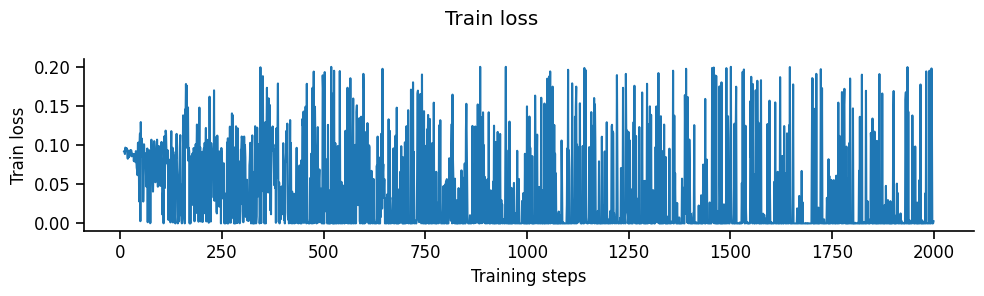

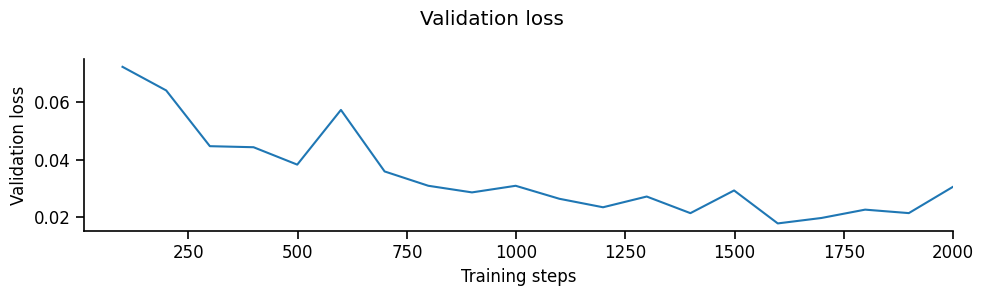

In [43]:
# Training parameters
# --------------------------
epochs = 1
train_steps = 2000  # 20000

# Train the network
# --------------------------
data_seed = 123 # Random seed for reproducibility. Ensures that the data is sampled in the same order each time.
data_generator.manual_seed(data_seed)
network.train(train_dataloader, val_dataloader, 
              samples_per_epoch=train_steps, 
              val_interval=(0, -1, 100),) 
            #   store_history=False,
            #   store_history_interval=(0, -1, 100), 
            #   store_dynamics=False, 
            #   store_params=False,
            #   status_bar=True)

# Plot training results
# --------------------------
eiann.plot.plot_train_loss_history(network, train_step_range=(10, train_steps))
eiann.plot.plot_validate_loss_history(network, train_step_range=(10, train_steps))


We can also build more complex "EI" networks with separate excitatory (E) and inhibitory (I) populations, where "Dale's law" (signed weights) is enforced for each population.

In [ ]:
EInetwork_config = eiann.NetworkBuilder()

# Define layers and populations
network_config.layer('Input').population('E', 784)
network_config.layer('H1').population('E', 500, 'relu').population('SomaI', 50, 'relu')
network_config.layer('H2').population('E', 500, 'relu').population('SomaI', 50, 'relu')
network_config.layer('Output').population('E', 10, 'relu').population('SomaI', 10, 'relu')

# Create connections between populations
network_config.connect(source='Input.E', target='H1.E').
network_config.connect(source='H1.E', target='H1.SomaI')
network_config.connect(source='H1.SomaI', target='H1.E')

network_config.connect(source='H1.E', target='H2.E')
network_config.connect(source='H2.E', target='H2.SomaI')
network_config.connect(source='H2.SomaI', target='H2.E')

network_config.connect(source='H2.E', target='Output.E')
network_config.connect(source='Output.E', target='Output.SomaI')
network_config.connect(source='Output.SomaI', target='Output.E')


# Set training parameters
EInetwork_config.training(
    tau=3,
    forward_steps=15,
    backward_steps=0,
    learning_rate=0.955
)


network_config.print_architecture()

# Build the network
network_seed = 42 # Random seed for network initialization (for reproducibility)
network = network_config.build(seed=network_seed)


Network Architecture:
Input.E (784) -> H1.E (500): Backprop (lr=0.001)
H1.SomaI (50) -> H1.E (500): No learning rule
H1.E (500) -> H1.SomaI (50): No learning rule
H1.E (500) -> H2.E (500): Backprop (lr=0.001)
H2.SomaI (50) -> H2.E (500): No learning rule
H2.E (500) -> H2.SomaI (50): No learning rule
H2.E (500) -> Output.E (10): Backprop (lr=0.001)
Output.SomaI (10) -> Output.E (10): No learning rule
Output.E (10) -> Output.SomaI (10): No learning rule
Network(
  (criterion): MSELoss()
  (module_dict): ModuleDict(
    (H1E_InputE): Projection(in_features=784, out_features=500, bias=False)
    (H1E_H1SomaI): Projection(in_features=50, out_features=500, bias=False)
    (H1SomaI_H1E): Projection(in_features=500, out_features=50, bias=False)
    (H2E_H1E): Projection(in_features=500, out_features=500, bias=False)
    (H2E_H2SomaI): Projection(in_features=50, out_features=500, bias=False)
    (H2SomaI_H2E): Projection(in_features=500, out_features=50, bias=False)
    (OutputE_H2E): Projectio

### 2.2. YAML interface

For more complex networks, combining multiple different learning rules with customized hyperparameters, we can also specify everything in .yaml configuration file

In [ ]:
network_name = "20231129_EIANN_2_hidden_mnist_van_bp_relu_SGD_config_G_complete_optimized"                          # Feedforward ANN (Backprop)
config_path = f"../EIANN/network_config/mnist/{network_name}.yaml"